Import the required packages and libraries.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

Read the metadata JSON file in order to build a dictionary and assign to each article a unique identifier (different from the DOI for easiest management of the network).

- metadata_dict -> contains all the articles and their data
- nodes -> dictionary containing tuples to map from DOI to node_id and journal title
- journals_dict -> dictionary to map from Journal_title to unique_id of the journal 

In [2]:
# Read metadata JSON file in order to build a dictionary
metadata = open("metadata.json")
metadata_dict = json.load(metadata)

# Create a dict of pairs "doi: (node_id, journal_title)"
nodes = dict()

# Create a dict of pairs "Journal: unique_identifier"
journals_dict = {}

# Add a number as unique identifier of each one of the papers and to each Journal
i = 0
j = 0
for paper in metadata_dict:
    paper["node_id"] = i
    nodes[paper['id']] = (paper['node_id'], paper['source_title'])
    i+=1
    if paper['source_title'] not in journals_dict:
        journals_dict[paper['source_title']] = j
        j+=1
    

Build the first network:
- journals_network -> such network will have the different journals as nodes; the edges will be weighted with the reciprocal of the number of citations of articles that goes from journal A to journal B. To be more accurate, it is correct to specify that target nodes without citations won't be considered at all, giving thus the possibility to avoid the definition of a normalization constant (that could have been useful to avoid 0-weigths in paths).

In [7]:
# Build the citations graph
journals_network = nx.DiGraph()

In order:
- Read the JSON file containing citations' pairs;
- Create a dictionary called "journal_citations" to store the different citations from journal to journal. The structure of this dictonary will be: "citing_journal_id: list_of_cited_journal_ids" (obviously, in the list we have repetitions of cited journals if articles cites more than one paper of the target journal);
- Populate the network as said above. This is accomplished thanks to a temporary "memo" dict that stores each citations to every target journal and that is initialized every time the source journal changes.
- Populate the "weights" dictionary. Such dictionary will contain the weight of each specific path retrieved and will be used to assign edge attributes to the network.
- article_citations contains pairs of "source article:[list of cited articles]".

<span style="color:red">Invertire e dare importanza alle citazioni ricevute, non a quelle fatte</span>

In [8]:
# Read citations JSON file in order to build a dictionary
citations = open('citations.json')
citations_dict = json.load(citations)
journal_citations = dict()
article_citations = dict()

In [9]:
# Iterate over citations_dict to build a journals citations' network
for citation_obj in tqdm(citations_dict):
    source = citation_obj['source']
    target = citation_obj['target']
    if source in nodes:
        if target in nodes:
            source_article = nodes[source][0]
            target_article = nodes[target][0]
            if source_article != target_article:
                if source_article not in article_citations:
                    article_citations[source_article] = list()
                article_citations[source_article].append(target_article)
                source_journal = nodes[source][1]
                target_journal = nodes[target][1]
                if source_journal in journals_dict:
                    if target_journal in journals_dict:
                        jorunal_source_id = journals_dict[source_journal]
                        journal_target_id = journals_dict[target_journal]
                        if jorunal_source_id not in journal_citations:
                            journal_citations[jorunal_source_id] = list()
                        journal_citations[jorunal_source_id].append(journal_target_id)

# Add nodes to the graph
weights = dict()

for source_id in journal_citations:
    memo = dict()
    for target_id in journal_citations[source_id]:
        if target_id not in memo:
            memo[target_id] = 0
        memo[target_id] += 1
    for cited_journal in memo:
        weights[(source_id, cited_journal)] = 1/memo[cited_journal]
        journals_network.add_edge(source_id, cited_journal)

100%|██████████| 189697/189697 [00:01<00:00, 166724.83it/s]


Assign edge_attributes to the network, according to the previously computed weights.

In [5]:
nx.set_edge_attributes(journals_network, weights, "betweenness")

Compute the "betweenness_centrality" measure to retrieve the most important journals. The parameter "weight" will contain the weights attributed to the network in the previous snippet.</br>
The "normalized=True" attribute is useful, in this case, because provides a normalization measure for the direct network.

In [6]:
journals_weighted_betweennes = nx.betweenness_centrality(journals_network, k=None, normalized=True, weight='betweenness', endpoints=False, seed=None)

Print the 100 most influential journals.

In [7]:
journals_influence = sorted(journals_weighted_betweennes.items(), key=lambda item: item[1], reverse=True)
journals_influence[:100]

[(24, 0.28175846307132224),
 (30, 0.0787274916323082),
 (129, 0.0615866332146319),
 (156, 0.057756211844293186),
 (41, 0.05396803220153811),
 (112, 0.04368358687736121),
 (66, 0.02815852917613958),
 (95, 0.027115148618240728),
 (53, 0.02238817025570451),
 (9, 0.02037088059900622),
 (44, 0.01821255362951039),
 (132, 0.013419361176865563),
 (74, 0.013226557194091947),
 (1768, 0.012307156991240072),
 (29, 0.011343009592483366),
 (131, 0.010360077685648698),
 (79, 0.008929569750468887),
 (452, 0.008724998131956123),
 (265, 0.007652387110309917),
 (319, 0.007623039568603626),
 (457, 0.006764983012768679),
 (179, 0.0052490732108770735),
 (379, 0.005004052458418592),
 (3610, 0.004922706692550782),
 (40, 0.004691704074375413),
 (100, 0.004629455024476058),
 (363, 0.004593342978475764),
 (57, 0.004438893735049145),
 (80, 0.0042549512529006725),
 (180, 0.003978886629197557),
 (138, 0.0036937679766701616),
 (137, 0.003659258597841062),
 (2684, 0.0035934035468065196),
 (165, 0.0029209077506857648)

Extract the title of the most influential journal.

In [8]:
for journal_title in journals_dict:
    if journals_dict[journal_title] == journals_influence[0][0]:
        most_influential_journal = journal_title
        break
most_influential_journal

'Journal Of Virology'

Count the number of outgoing edges from each article in the dataset.

In [9]:
# Raw count of how many articles each specific article cites
article_citations_tot = dict()

for citation in citations_dict:
    if citation['source'] in nodes:
        source_article_id = nodes[citation['source']][0]
        if citation['target'] in nodes:
            target_article_id = nodes[citation['target']][0]
            if source_article_id != target_article_id:
                if source_article_id not in article_citations_tot:
                    article_citations_tot[source_article_id] = 0
                article_citations_tot[source_article_id] += 1

Build a "journals_sizes" dictionary, containing pairs "journal_id: journal_size", retrieved by the betweenness centrality dictionary computed above.

In [10]:
journal_influences = journals_weighted_betweennes

In the following snippet, is given a weight to citations between articles.</br>
Such weight is computed in the following way:
- $n$ is the raw count of out-going citations from a certain article;
- $\alpha$ is the influence of the specific journal containing the citing article (computed with the betweenness centrality measure);
- $\lambda$ is a constant ($\lambda = 0.1$) that is useful to normalize weights equal to $0$;
</br>
Following a flow of information that goes from the source article to the cited one, the relative weight ($\Phi_{ij}$) of the connection between "article $A$" and "article $B$" is computed as follows:</br>

$$\Phi_{AB} = \dfrac{\alpha + \lambda}{n}$$ 
</br>

The idea behind this computation derives from the will to distribute the importance of a certain article between all the articles that it cites in an equal way. Furthermore, higher the number of cited articles -> smaller the importance passed to each one of them.


In [11]:
# articles_weights contains pairs of "(tuple source-target): weight of the connection"
articles_weights = dict()

for citation in citations_dict:
    found_all = False
    if citation['source'] in nodes:
        source_article_id = nodes[citation['source']][0]
        source_journal = nodes[citation['source']][1]
        if source_journal in journals_dict:
            source_journal_id = journals_dict[source_journal]
            if source_journal_id in journal_influences:
                if source_article_id in article_citations_tot:
                    article_distributed_weight = ((0.1 + journal_influences[source_journal_id])/article_citations_tot[source_article_id])
                    found_all = True
    if found_all:
        if source_article_id in article_citations:
            for cited_article_id in article_citations[source_article_id]:
                if source_article_id != cited_article_id:
                    articles_weights[(source_article_id, cited_article_id)] = article_distributed_weight

------
Below is provided a function to retrieve all the publications within each specific journal. Such function won't be used but may be useful for others who want to analyze more than a single journal.

In [12]:
# journals_articles contains pairs of "journal_id: list(article_ids of articles in that journal)"
journals_articles = dict()

for doi in nodes:
    journal_title = nodes[doi][1]
    if journal_title in journals_dict:
        journal_id = journals_dict[journal_title]
        if journal_id not in journals_articles:
            journals_articles[journal_id] = list()
        journals_articles[journal_id].append(nodes[doi][0])

-------

Build a new network, that is the citation network of publications contained within the most influential journal.

In [13]:
publications_network = nx.DiGraph()

Retrieve all the publications within the most influential journal and populate the previously created citation network with them.

In [14]:
weighted_citations_in_journal = dict()

for citation in tqdm(citations_dict):
    if citation['source'] in nodes:
        if nodes[citation['source']][1] == most_influential_journal:
            source = nodes[citation['source']][0]
            if citation['target'] in nodes:
                if nodes[citation['target']][1] == most_influential_journal:
                    target = nodes[citation['target']][0]
                    if source != target:
                        weighted_citations_in_journal[(source, target)] = articles_weights[(source, target)]
                        publications_network.add_edge(source, target)

100%|██████████| 189697/189697 [00:00<00:00, 1428053.03it/s]


Set the weights of edges within the most influential journal citations network.

In [15]:
nx.set_edge_attributes(publications_network, weighted_citations_in_journal, "eigenvector_values")

Finally, we compute the eigenvector centrality in order to find which publications can be identified as key publications within the most influential journal.

In [16]:
key_papers = nx.eigenvector_centrality(publications_network, max_iter=1000, weight='eigenvector_values')

In [17]:
three_key_papers = sorted(key_papers.items(), key=lambda item: item[1], reverse=True)[:3]
three_key_papers

[(6389, 0.9328506736879955),
 (29134, 0.1353611088264001),
 (10199, 0.11319512049689386)]

Retrieve the 3 most important papers within the most influential journal.

In [18]:
for paper in metadata_dict:
    if paper['node_id'] == three_key_papers[0][0]:
        key_paper_1 = paper
    if paper['node_id'] == three_key_papers[1][0]:
        key_paper_2 = paper
    if paper['node_id'] == three_key_papers[2][0]:
        key_paper_3 = paper

Print the results.

In [19]:
key_paper_1

{'id': '10.1128/jvi.01245-08',
 'author': 'KräHling, Stein, Spiegel, Weber, MüHlberger',
 'year': '2008',
 'title': 'Severe Acute Respiratory Syndrome Coronavirus Triggers Apoptosis Via Protein Kinase R But Is Resistant To Its Antiviral Activity',
 'source_title': 'Journal Of Virology',
 'node_id': 6389}

In [20]:
key_paper_2

{'id': '10.1128/jvi.02744-05',
 'author': 'Li, Berardi, Li, Farzan, Dormitzer, Harrison',
 'year': '2006',
 'title': 'Conformational States Of The Severe Acute Respiratory Syndrome Coronavirus Spike Protein Ectodomain',
 'source_title': 'Journal Of Virology',
 'node_id': 29134}

In [21]:
key_paper_3

{'id': '10.1128/jvi.00442-08',
 'author': 'Li',
 'year': '2008',
 'title': 'Structural Analysis Of Major Species Barriers Between Humans And Palm Civets For Severe Acute Respiratory Syndrome Coronavirus Infections',
 'source_title': 'Journal Of Virology',
 'node_id': 10199}

In [22]:
nx.write_gml(publications_network, "pub_network.gml")
nx.write_gml(journals_network, "journals_network.gml")

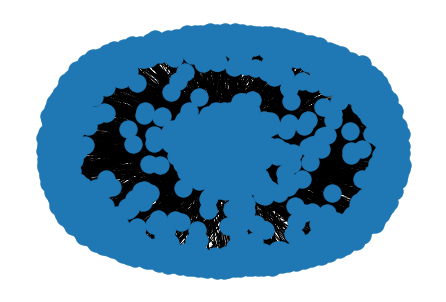

In [23]:
nx.draw(publications_network)